In [1]:
# Script to examine bitcoin's vix correlations and whether it has the 
# potential to become a long-volatility asset during times of 
# global instability.

# Reference: 
# https://dataalways.substack.com/p/is-bitcoin-long-volatility

In [2]:
# Author: T. from Data Always. 
# Twitter: @Data_Always
# Substack: dataalways.substack.com
 
# Last modified: June 24, 2022

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# Initialize a coinmetrics API client
from coinmetrics.api_client import CoinMetricsClient
client = CoinMetricsClient()

# Start date for the API requests
# we clip all data pre ether's inception so no reason to go earlier
data_date = '2015-01-01'

In [4]:
# Function definition for printing the data source in the bottom left of the figure
def source(src_string, fontsize=12):
    ax = plt.gca()
    props = dict(alpha=0)
    ax.text(0.0, -0.12, 
            f"Source(s): {src_string}", 
            transform=ax.transAxes, 
            fontsize=fontsize, 
            verticalalignment='bottom', 
            bbox=props
           )     

In [5]:
# Default plot settings
def set_plt_defaults():
    plt.rcParams['figure.figsize'] = (12,8)
    plt.rcParams['figure.subplot.left'] = 0.10
    plt.rcParams['figure.subplot.top'] = 0.88
    plt.rcParams['figure.subplot.right'] = 0.95
        
    fig_out = plt.figure()
    ax_out = plt.subplot2grid((1,1), (0,0))
    # Assign the outputs to return.
    
    plt.grid(color=[0.25, 0.25, 0.25], 
             linestyle='-', 
             linewidth=0.75, 
             alpha=0.25, 
             zorder=0)
    # Gridline styling
    
    ax_out.xaxis.grid()
    # Only plot horizontal gridlines.

    ax_out.axhline(linewidth=1, color='black')
    # Plot the x-axis zero-line

    plt.box(False)

    return fig_out, ax_out

In [6]:
# Download the data for bitcoin from Coin Metrics
btc_data = client.get_asset_metrics(
    assets=['btc'], # btc, eth, ada
    metrics=['ReferenceRate'],
    start_time=f'{data_date}T00:00:00Z',
    frequency='1d-ny-close'
)
df = btc_data.to_dataframe()

df['date'] = [str(x)[:10] for x in df['time']]
# Extract just the YYYY-MM-DD from the full datetime

df['Bitcoin'] = df['ReferenceRate']
# Extract the price by duplicating so date remains the first column

df.drop(columns=['asset', 'time', 'ReferenceRate'], axis=1, inplace=True)
# Drop unwanted columns


In [7]:
# Download the data for ether from Coin Metrics.
eth_data = client.get_asset_metrics(
    assets=['eth'],
    metrics=['ReferenceRate'],
    start_time=f'{data_date}T00:00:00Z',
    frequency='1d-ny-close'
)
ETH = eth_data.to_dataframe()

ETH['date'] = [str(x)[:10] for x in ETH['time']]
# Extract the date in YYYY-MM-DD

ETH = ETH.drop(columns=['asset', 'time'], axis=1)
# Drop the unwatned columns

ETH = ETH.rename(columns={"ReferenceRate": "Ethereum"})
# Rename 4pm ReferenceRate to Ethereum 

df = df.merge(ETH, on="date", how="outer")
# Merge the dataframes

df.tail()

,date,Bitcoin,Ethereum
2727,2016-12-28,968.391206,7.601107
2728,2016-12-29,962.11172,8.323546
2729,2016-12-30,959.748768,8.245705
2730,2016-12-31,964.263585,8.085167
2731,2017-01-01,1000.456696,8.213454


In [8]:
# Dowload the VIX data from CBOE
VIX = pd.read_csv('https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv')

# Only keep the daily close data
VIX = VIX.drop(columns=['OPEN', 'HIGH', 'LOW'], axis=1)
VIX = VIX.rename(columns={"DATE": "date", "CLOSE": "VIX"})

# Convert the date formatting to match pandas
new_data = []
for ii in range(len(VIX)):
    month = VIX['date'][ii][:2]
    day = VIX['date'][ii][3:5]
    year =  VIX['date'][ii][-4:]
    new_data.append(f'{year}-{month}-{day}')

VIX['date'] = pd.DataFrame(new_data)

# Toss old data and then merge it in with the crypto data
VIX = VIX[VIX['date'] >= data_date]
df = df.merge(VIX, on="date", how="outer")

In [9]:
# Sort the data and swap the index to date
df['date'] = [pd.to_datetime(x) for x in df['date']]
df = df.sort_values(by="date")
df = df.set_index(pd.DatetimeIndex(df['date']))

# Let's throw out any old data.
df = df[df['date'] >= pd.to_datetime(data_date)]

In [10]:
# Lets set up for a safe correlation calculation
# ie: drop any data point if there is even a single missing value. 
df.dropna(axis=0, how='any', inplace=True)

df.tail()

,date,Bitcoin,Ethereum,VIX
date,,,,
2022-06-17,2022-06-17,20486.946279,1078.671421,31.13
2022-06-20,2022-06-20,20057.065914,1103.211181,31.03
2022-06-21,2022-06-21,21053.376914,1136.473571,30.19
2022-06-22,2022-06-22,20060.210062,1069.66777,28.95
2022-06-23,2022-06-23,20770.470786,1119.990675,29.05


In [11]:
# clean Coin Metrics data styling. (Float64 to float64)
df['Bitcoin'] = df['Bitcoin'].replace('None', '0').astype(float)
df['Ethereum'] = df['Ethereum'].replace('None', '0').astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1733 entries, 2015-08-10 to 2022-06-23
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1733 non-null   datetime64[ns]
 1   Bitcoin   1733 non-null   float64       
 2   Ethereum  1733 non-null   float64       
 3   VIX       1733 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 67.7 KB


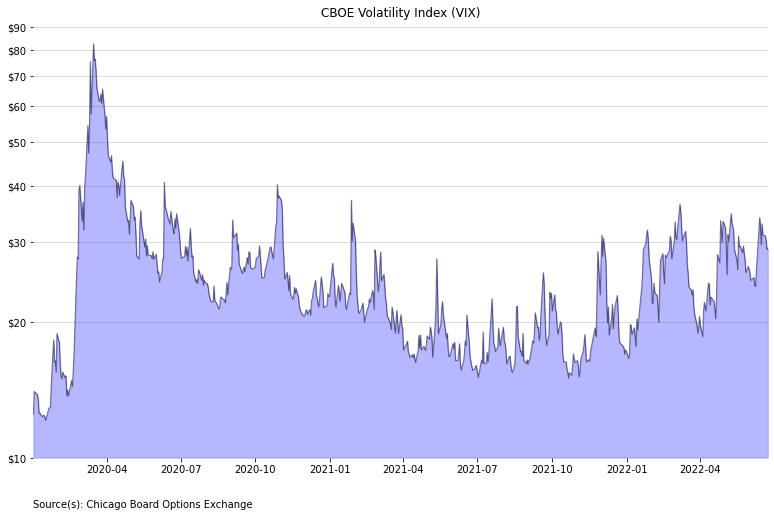

In [12]:
# Let's plot the VIX 
tick_size = 14

start_date = '2019-12-31'
tmp_df = df[df['date'] > start_date]

fig, ax1 = set_plt_defaults()
plt.title('CBOE Volatility Index (VIX)')
ax1.plot(tmp_df['date'], tmp_df['VIX'], 'k-', lw=1, alpha=0.5)
ax1.fill_between(tmp_df['date'], tmp_df['VIX'], [10]*len(tmp_df['date']), color=[0.3, 0.3, 1], alpha=0.4)

ax1.set_xlim(tmp_df['date'][0], tmp_df['date'][-1])
ax1.set_yscale('log')
ax1.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90])
ax1.set_ylim([10, 92])
ax1.set_yticklabels(['${:,.0f}'.format(x) for x in ax1.get_yticks()])

source('Chicago Board Options Exchange', fontsize=10)
plt.savefig('./vix-chart.png', transparent=False, facecolor='white')
plt.show()

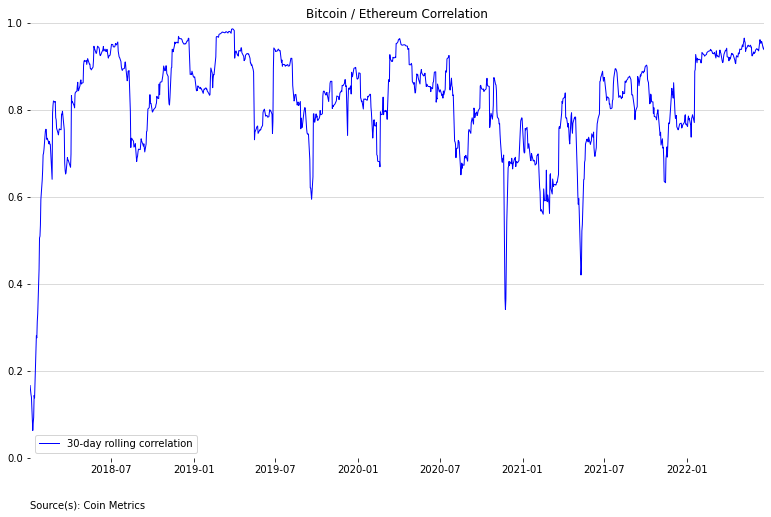

In [15]:
# Let's take a look at the correlation between bitcoin and ethereum
df['btc-eth-15-day'] = df['Ethereum'].pct_change().rolling(15).corr(df['Bitcoin'].pct_change())
df['btc-eth-30-day'] = df['Ethereum'].pct_change().rolling(30).corr(df['Bitcoin'].pct_change())

# Choose our time window
start_date = '2017-12-31'
tmp_df = df[df['date'] > start_date]

fig, ax1 = set_plt_defaults()
plt.title('Bitcoin / Ethereum Correlation')

ax1.plot(tmp_df['date'], 
         tmp_df['btc-eth-30-day'], 
         ls = '-', 
         color = 'b', 
         lw=1,
         label = '30-day rolling correlation')
# Plot the 30 day rolling correlation

#ax1.plot(tmp_df['date'], 
#         tmp_df['btc-eth-15-day'], 
#         ls = '-', 
#         color = 'r', 
#         lw=1,
#         label = '15-day rolling correlation')
## Plot the 15 day rolling correlation

ax1.set_xlim(tmp_df['date'][0], tmp_df['date'][-1])
ax1.set_ylim([0, 1])
# Set plot boundaries

plt.legend()

source('Coin Metrics', fontsize=10)
plt.savefig('btc-eth-correlation.png', transparent=False, facecolor='white')
plt.show()

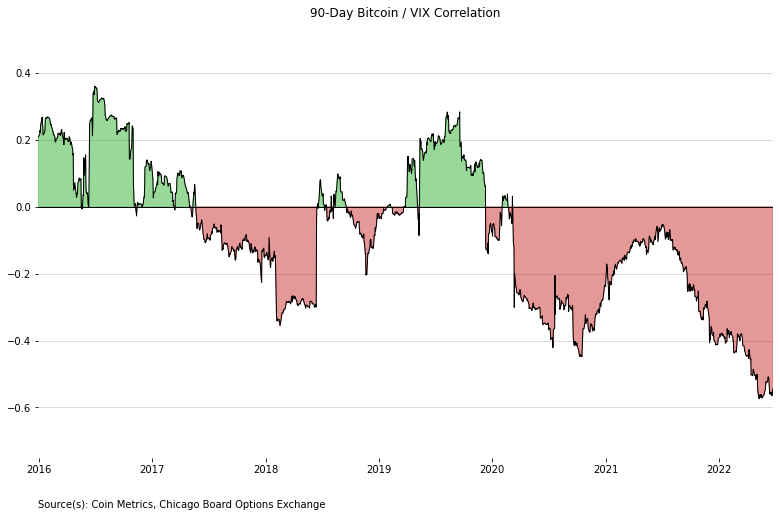

In [16]:
# Let's take a longer and cleaner look at bitcoin's vix correlation 
df['btc-15-day'] = df['Bitcoin'].pct_change().rolling(15).corr(df['VIX'].pct_change())
df['btc-30-day'] = df['Bitcoin'].pct_change().rolling(30).corr(df['VIX'].pct_change())
df['btc-90-day'] = df['Bitcoin'].pct_change().rolling(90).corr(df['VIX'].pct_change())

start_date = '2015-12-30'
tmp_df = df[df['date'] > start_date]

fig, ax1 = set_plt_defaults()
plt.title('90-Day Bitcoin / VIX Correlation')

# Plot the outline of the curve
ax1.plot(tmp_df['date'], tmp_df['btc-90-day'], 
         ls = '-', 
         color = 'k', 
         lw=1)

# Plot long-volatility correlations in green
ax1.fill_between(tmp_df['date'], tmp_df['btc-90-day'], 
                 where=tmp_df['btc-90-day'] > 0, 
                 color=[0.2, 0.7, 0.2], 
                 alpha=0.5)

# Plot short-volatility correlations in green
ax1.fill_between(tmp_df['date'], tmp_df['btc-90-day'], 
                 where=tmp_df['btc-90-day'] < 0, 
                 color=[0.8, 0.2, 0.2], 
                 alpha=0.5)


ax1.set_xlim(tmp_df['date'][0], tmp_df['date'][-1])
ax1.set_ylim([-0.75, 0.55])


source('Coin Metrics, Chicago Board Options Exchange', fontsize=10)

plt.savefig('./btc-vix-longterm-correlation.png', transparent=False, facecolor='white')
plt.show()

In [17]:
# Okay, now let's do some case studies around specific global events
# - Trump failed re-election + Jan 6
# - Evergrande
# - ??? 

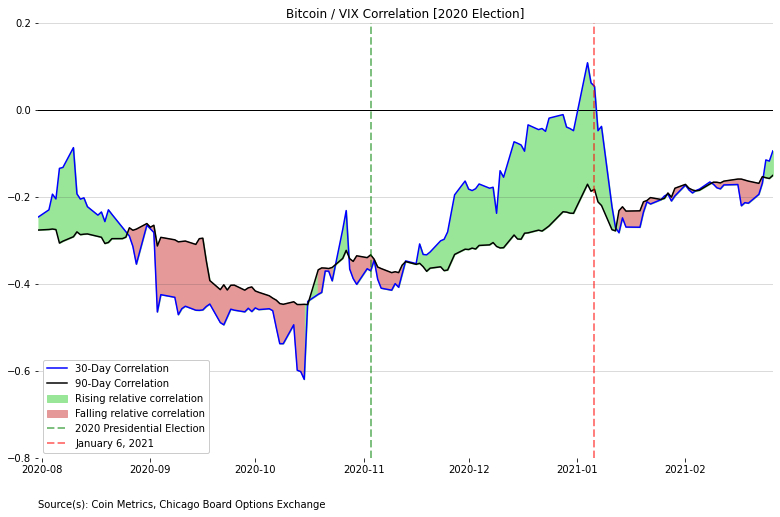

In [26]:
# US Election: Nov 2020
start_date = pd.to_datetime('2020-07-30')
end_date = pd.to_datetime('2021-02-28')
tmp_df = df[df['date'] > start_date]
tmp_df = tmp_df[tmp_df['date'] <= end_date]
# Time window of interest

fig, ax1 = set_plt_defaults()
plt.title('Bitcoin / VIX Correlation [2020 Election]')

ax1.plot(tmp_df['date'], 
         tmp_df['btc-30-day'], 
         ls = '-', 
         color = 'b', 
         lw=1.5, 
         label='30-Day Correlation')
# Plot the 30 day correlation

ax1.plot(tmp_df['date'], 
         tmp_df['btc-90-day'], 
         ls = '-', 
         color = 'k', 
         lw=1.5, 
         label='90-Day Correlation')
# Plot the 90 day correlation

ax1.fill_between(x = tmp_df['date'], 
                 y1 = tmp_df['btc-30-day'], 
                 y2 = tmp_df['btc-90-day'], 
                 #where = tmp_df['btc-30-day'] >= tmp_df['btc-90-day'],
                 color = [0.6, 0.9, 0.6], 
                 alpha = 1,
                 label = 'Rising relative correlation')
# Color in times of higher relative short term correlations

ax1.fill_between(x = tmp_df['date'], 
                 y1 = tmp_df['btc-30-day'], 
                 y2 = tmp_df['btc-90-day'], 
                 where = tmp_df['btc-30-day'] <= tmp_df['btc-90-day'],
                 color = [0.9, 0.6, 0.6], 
                 alpha = 1,
                 label = 'Falling relative correlation')
# Color in times of lower relative short term correlations

ax1.axvline(x = pd.to_datetime('2020-11-03'), 
            ymin = 0, ymax = 1, 
            ls = '--', 
            color = 'g', 
            lw = 2, 
            alpha = 0.5,
            label = '2020 Presidential Election')
# Plot a vertical line at the time of the election

ax1.axvline(x = pd.to_datetime('2021-01-06'), 
            ymin = 0, ymax = 1, 
            ls = '--', 
            color = 'r', 
            lw = 2, 
            alpha = 0.5,
            label = 'January 6, 2021')
# Plot a vertical line at the time of the January 6

ax1.set_xlim(tmp_df['date'][0], tmp_df['date'][-1])
ax1.set_ylim([-0.8, 0.2])
# Boundaries for the plot

ax1.legend(framealpha=1)
# Legend with solid background

source('Coin Metrics, Chicago Board Options Exchange', fontsize=10)
plt.savefig('./btc-vix-election.png', transparent=False, facecolor='white')

plt.show()

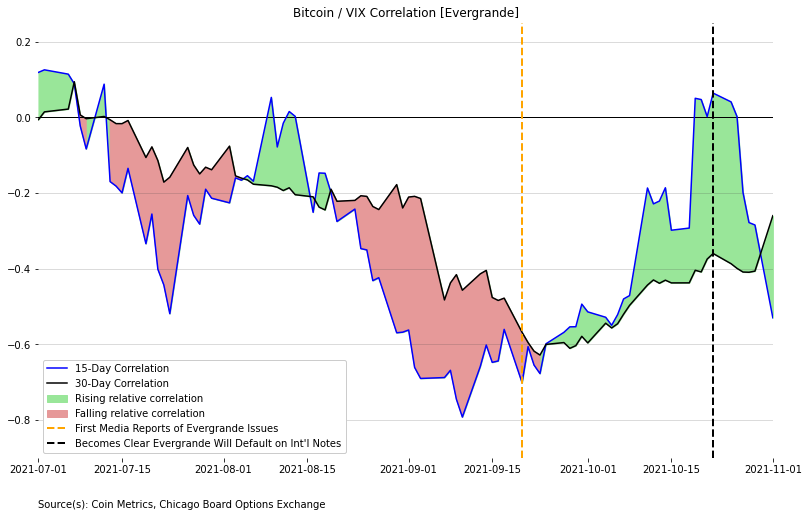

In [32]:
# Let's look at Evergrande: [Starting Sept 21, 2021]
ws=1
start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-11-01')
tmp_df = df[df['date'] > start_date]
tmp_df = tmp_df[tmp_df['date'] <= end_date]

fig, ax1 = set_plt_defaults()
plt.title('Bitcoin / VIX Correlation [Evergrande]')

ax1.plot(tmp_df['date'], 
         tmp_df['btc-15-day'], 
         ls = '-', 
         color = 'b', 
         lw=1.5, 
         label='15-Day Correlation')
# Plot the 15 day correlation

ax1.plot(tmp_df['date'], 
         tmp_df['btc-30-day'], 
         ls = '-', 
         color = 'k', 
         lw=1.5, 
         label='30-Day Correlation')
# Plot the 30 day correlation

ax1.fill_between(x = tmp_df['date'], 
                 y1 = tmp_df['btc-15-day'], 
                 y2 = tmp_df['btc-30-day'], 
                 #where = tmp_df['btc-15-day'] >= tmp_df['btc-30-day'],
                 color=[0.6, 0.9, 0.6], 
                 alpha = 1,
                 label = 'Rising relative correlation')
# Color in times of higher relative short term correlations

ax1.fill_between(x = tmp_df['date'], 
                 y1 = tmp_df['btc-15-day'], 
                 y2 = tmp_df['btc-30-day'], 
                 where = tmp_df['btc-15-day'] <= tmp_df['btc-30-day'],
                 color = [0.9, 0.6, 0.6], 
                 alpha = 1,
                 label = 'Falling relative correlation')
# Color in times of lower relative short term correlations


ax1.axvline(x = pd.to_datetime('2021-09-20'), 
            ymin = 0, 
            ymax = 1, 
            ls = '--', 
            color = 'orange', 
            lw = 2, 
            label = 'First Media Reports of Evergrande Issues')


ax1.axvline(x = pd.to_datetime('2021-10-22'), 
            ymin = 0, 
            ymax = 1, 
            ls = '--', 
            color = 'k', 
            lw = 2, 
            label = 'Becomes Clear Evergrande Will Default on Int\'l Notes')


ax1.set_xlim(tmp_df['date'][0], tmp_df['date'][-1])
ax1.set_ylim([-0.9, 0.25])
# Plot boundaries

ax1.legend(framealpha=1)


source('Coin Metrics, Chicago Board Options Exchange', fontsize=10)
plt.savefig('./btc-vix-evergrande.png', transparent=False, facecolor='white')
plt.show()